In [1]:
import pickle
import h5py
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [20]:
filenum=18
CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
# open 
f = h5py.File(CAT, 'r')

pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
SFR_sh = f['Subhalo/SubhaloSFRinMaxRad'][:]
subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h
nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
# close file
f.close()

fits_file_path = f'LH_ellipticities/CAMELS_data_LH{filenum}.fits'

with fits.open(fits_file_path) as hdul:
    data = hdul[1].data

# Now you can use the same variable names
pos_g = np.array([data['x'], data['y'], data['z']]).T
print(pos_sh.shape, pos_g.shape)

(13534, 3) (242, 3)


In [21]:
# Use broadcasting to compare all elements
indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
consistent = pos_g.shape[0]==indices.shape[0]
print(indices.shape[0],"=",pos_g.shape[0]," ",consistent)

242 = 242   True


In [22]:
if consistent:
    print(len(SFR_sh[indices]))
    print(sum(SFR_sh[indices]>0.1))

242
139


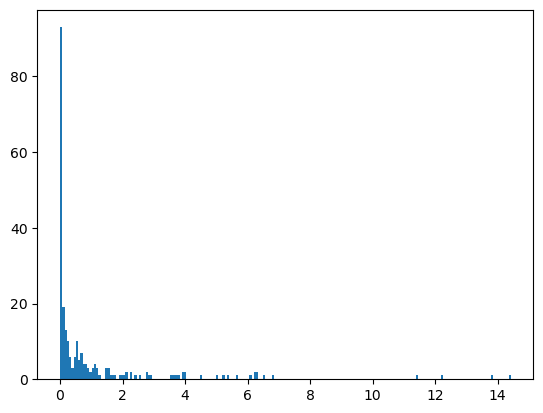

In [23]:
plt.hist(SFR_sh[indices],bins=200)
plt.xscale('linear')
plt.show()

In [130]:
all_SFR = np.array([])
all_M_R_12 = np.array([])
all_nstar = np.array([])
all_gas = np.array([])
filt_SFR = np.array([])
filt_M_R_12 = np.array([])
filt_nstar = np.array([])
filt_gas = np.array([])
for filenum in range(1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10
    nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
    ngas_sh = f['Subhalo/SubhaloLenType'][:,0]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LH{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data

    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
#     print(pos_sh.shape, pos_g.shape)

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(indices.shape[0],"=",pos_g.shape[0]," ",consistent)
    # filter out elliptical
    if consistent:
#         print(len(SFR_sh[indices]))
#         print(sum(SFR_sh[indices]>0.1))
        all_SFR = np.append(all_SFR,SFR_sh)
        filt_SFR = np.append(filt_SFR,SFR_sh[indices])
        all_M_R_12 = np.append(all_M_R_12, subh_M_R_12)
        filt_M_R_12 = np.append(filt_M_R_12, subh_M_R_12[indices])
        all_nstar = np.append(all_nstar, nstar_sh)
        filt_nstar = np.append(filt_nstar, nstar_sh[indices])
        all_gas = np.append(all_gas, ngas_sh)
        filt_gas = np.append(filt_gas, ngas_sh[indices])
    else:
        print('Not consistent')


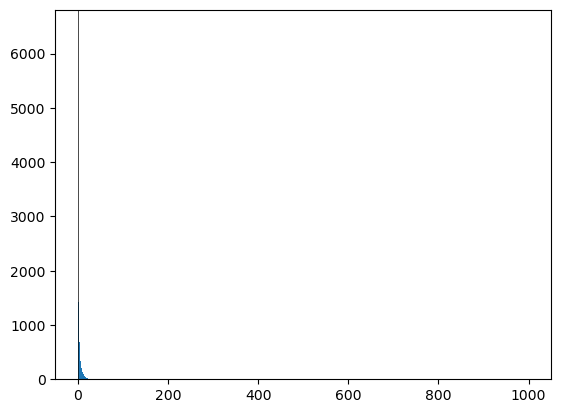

In [74]:
plt.hist(all_SFR,bins=np.logspace(0-4,3,500))
plt.axvline(0.012,c='k',lw=0.5)
plt.xscale('log')
plt.show()

In [172]:
SF = np.where(filt_SFR!=0)[0]
print(len(SF)/len(filt_SFR))
NSF = np.where(filt_SFR==0)[0]

0.6166339114358445


Text(0, 0.5, 'n stars')

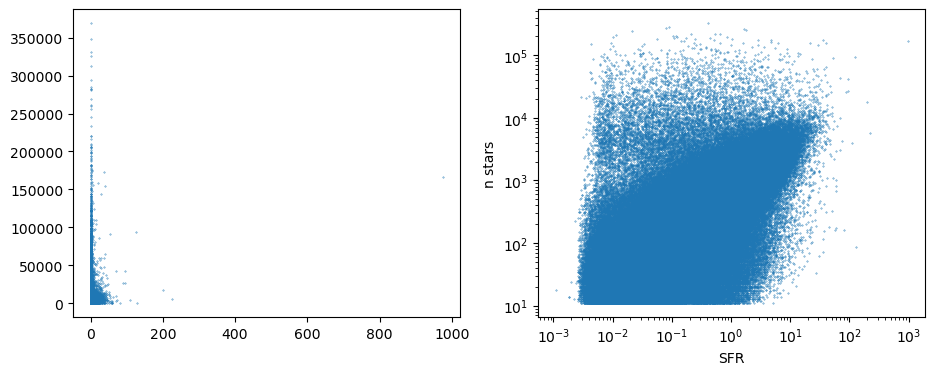

In [190]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))

ax[0].scatter(filt_SFR, filt_nstar , s=0.1)
ax[1].scatter(filt_SFR[SF], filt_nstar[SF] , s=0.1)
# plt.hist2d(all_SFR[filt] , all_M_R_12[filt],cmap='bone',bins=np.logspace(0-4,3,50))
ax[1].set_xscale('log'); ax[1].set_yscale('log')
# plt.xlim([-1,10])
plt.xlabel('SFR'); plt.ylabel('n stars')

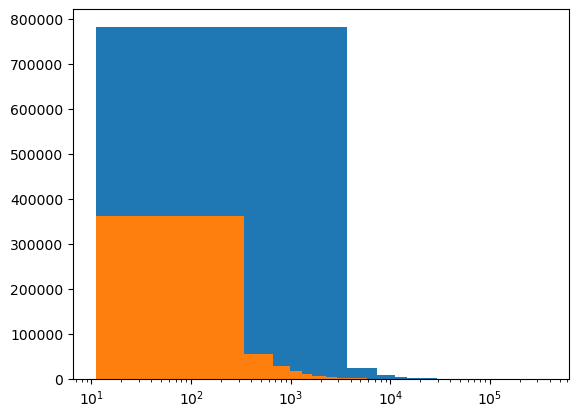

In [198]:
SF = np.where(filt_SFR!=0)[0]
NSF = np.where(filt_SFR==0)[0]
plt.hist(filt_nstar , bins=100)
plt.hist(filt_nstar[SF] , bins=1000)
plt.xscale('log')
plt.show()


In [78]:
print(len(filt_M_R_12), len(all_M_R_12),len(all_SFR), len(filt_M_R_12),len(all_nstar), len(filt_nstar) )

823787 16879689 16879689 823787 16879689 823787


Filter out 95.12% of subhalos. and 1 - 504388/748761 = 32.26% of subhalos with non-zero SFR

In [171]:
SF_ = np.where(all_SFR!=0)[0]
print(len(SF_)/len(all_SFR))
NSF_ = np.where(all_SFR==0)[0]

0.044639033337640285


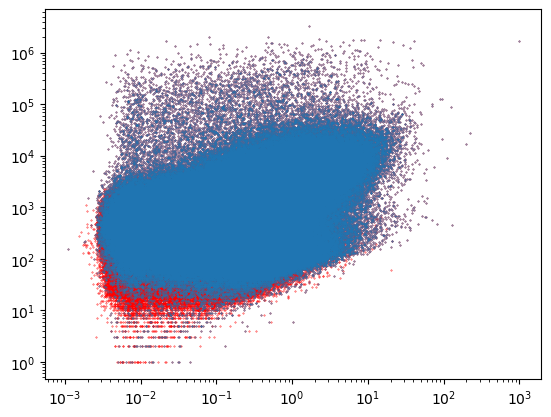

In [187]:
plt.scatter(all_SFR[SF_], all_gas[SF_] , s=0.1,c='red')
plt.scatter(filt_SFR[SF], filt_gas[SF] , s=0.1)
# plt.hist2d(all_SFR , all_gas,cmap='bone',bins=(np.logspace(1e-6,5,256),np.logspace(1e-6,2e6,256)))
plt.xscale('log'); plt.yscale('log')
# plt.xlim([-0.1,5]); plt.ylim([-1e5,2e6])

In [169]:
print(len(all_SFR),len(filt_SFR[SF]))

16879689 507975
